#### Importing essential libraries

In [1]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import urllib.request
import pandas as pd
import scipy.sparse as sp
import os
from tqdm.notebook import tqdm
from torchmetrics.functional import f1_score
from matplotlib import pyplot as plt
import seaborn as sns

#### Reading the dataset

The dataset I have worked on here is ‘Computer’ part of the AmazonCoBuy dataset, where nodes (total 13,752) represent goods, edges (total 4,91,722) indicate that two goods are frequently bought together, node features (totl 767) are bag-of-words encoded product reviews, and class labels (total 10) are given by the product category.

You can find more such datasets here: https://docs.dgl.ai/en/0.8.x/api/python/dgl.data.html



In [2]:
dataset = dgl.data.AmazonCoBuyComputerDataset()
g = dataset[0]
num_classes = dataset.num_classes
feat = g.ndata['feat']
label = g.ndata['label']

In [3]:
g

Graph(num_nodes=13752, num_edges=491722,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(767,), dtype=torch.float32)}
      edata_schemes={'__orig__': Scheme(shape=(), dtype=torch.int64)})




Adding self-loops regardless of whether they already exist or not, where 'features' of the new edges (self-loop edges) will be filled with zeros.

In [4]:
g = dgl.add_self_loop(g)

train_mask: A boolean tensor indicating whether the node is in the training set.

val_mask: A boolean tensor indicating whether the node is in the validation set.

test_mask: A boolean tensor indicating whether the node is in the test set.

In [5]:
#Creating train-val-test mask of 80-10-10

g.ndata['train_mask']=torch.as_tensor([True]*11000+[False]*1376+[False]*1376)
g.ndata['val_mask']=torch.as_tensor([False]*11000+[True]*1376+[False]*1376)
g.ndata['test_mask']=torch.as_tensor([False]*11000+[False]*1376+[True]*1376)

#### Defining Model

I have implemented a Graph Convolutional Network (GCN) with 2 layers here. 

You can read more about it here: http://tkipf.github.io/graph-convolutional-networks/

In [6]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

# Creating the model with given dimensions
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)
model

GCN(
  (conv1): GraphConv(in=767, out=16, normalization=both, activation=None)
  (conv2): GraphConv(in=16, out=10, normalization=both, activation=None)
)

#### Training the Model

In [7]:

lossl=[]
ep=[]
train_accl=[]
val_accl=[]
test_accl=[]
    
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_train_acc = 0
    best_val_acc = 0
    best_test_acc = 0
    
    

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    for e in tqdm(range(2001)):
        # Forward function
        logits = model(g, features)

        # Computing prediction 
        pred = logits.argmax(1)

        # Computing the loss of only compute the losses of the nodes in the training set
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Computing the training/validation/test accuracy 
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()
        

        # Saving the best train, validation, and test accuracy
        if best_train_acc < train_acc:
            best_train_acc = train_acc
        if best_val_acc < val_acc:
            best_val_acc = val_acc
        if best_test_acc < test_acc:
            best_test_acc = test_acc

        # Performing backward propagation
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 200 == 0:
            print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))
            
            #storing loss value, and train-val-test accuracy
            lossl.append(loss.detach().numpy())
            ep.append(e)
            train_accl.append(train_acc.detach().numpy())
            val_accl.append(val_acc.detach().numpy())
            test_accl.append(test_acc.detach().numpy())
        
        
        
        

#Training the model
train(g, model)

  0%|          | 0/2001 [00:00<?, ?it/s]

/Users/sganguly/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In epoch 0, loss: 2.360, val acc: 0.088 (best 0.088), test acc: 0.025 (best 0.025)
In epoch 200, loss: 0.330, val acc: 0.803 (best 0.803), test acc: 0.695 (best 0.695)
In epoch 400, loss: 0.240, val acc: 0.849 (best 0.849), test acc: 0.722 (best 0.722)
In epoch 600, loss: 0.207, val acc: 0.863 (best 0.869), test acc: 0.727 (best 0.730)
In epoch 800, loss: 0.188, val acc: 0.864 (best 0.873), test acc: 0.725 (best 0.732)
In epoch 1000, loss: 0.197, val acc: 0.863 (best 0.873), test acc: 0.729 (best 0.732)
In epoch 1200, loss: 0.185, val acc: 0.866 (best 0.873), test acc: 0.726 (best 0.732)
In epoch 1400, loss: 0.180, val acc: 0.868 (best 0.873), test acc: 0.730 (best 0.732)
In epoch 1600, loss: 0.175, val acc: 0.871 (best 0.873), test acc: 0.731 (best 0.733)
In epoch 1800, loss: 0.171, val acc: 0.871 (best 0.873), test acc: 0.730 (best 0.733)
In epoch 2000, loss: 0.166, val acc: 0.868 (best 0.873), test acc: 0.728 (best 0.733)


#### Plotting the performance of the GCN model

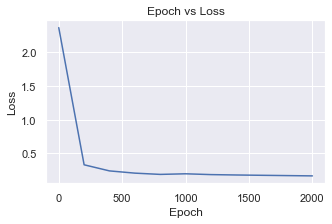

In [8]:
plt.figure(figsize=(5,3))
sns.set_theme(style="darkgrid")
plt.plot(ep, lossl)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.show()

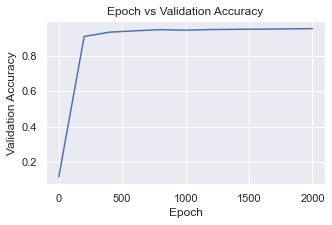

In [9]:
plt.figure(figsize=(5,3))
sns.set_theme(style="darkgrid")
plt.plot(ep, train_accl)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Epoch vs Validation Accuracy")
plt.show()

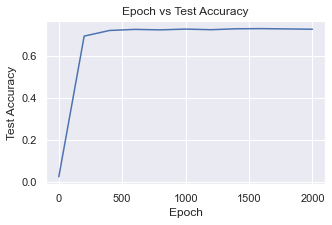

In [10]:
plt.figure(figsize=(5,3))
sns.set_theme(style="darkgrid")
plt.plot(ep, test_accl)
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Epoch vs Test Accuracy")
plt.show()